In [14]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import netCDF4 as nc
from library import rand_svd, make_movie, dmd, mask_sst
import pywt

In [16]:
# Load data

data_dir = '/cnl/data/spate/Datasets/'
save_dir = '/cnl/data/spate/Corn/'
do_mean_sub = True # Whether to mean-center

# Read in the netcdf files
sst_ds = nc.Dataset(data_dir + 'sst.wkmean.1990-present.nc', 'r')
mask_ds = nc.Dataset(data_dir + 'lsmask.nc', 'r')

# Get data in numpy arrays
sst = sst_ds['sst'][:].data.astype(np.float64)
mask = mask_ds['mask'][:].data.astype(bool)
time = sst_ds['time'][:] / 365 + 1800
lat = sst_ds['lat'][:]
long = sst_ds['lon'][:] # Degrees east

# Transpose to (lat, long, time)
mask = np.transpose(mask, axes=[1,2,0])
sst = np.transpose(sst, axes=[1,2,0])

lat_span, long_span, t_span = sst.shape

# Extract data corresponding to bodies of water
sst_st = sst.reshape(-1, t_span) # Shape to space x time matrix
sst_st = sst_st[mask.reshape(-1,), :]

sst_raw = sst_st.copy() # Save actual temps before mean centering

# Mean center
if do_mean_sub:
    ave_week = sst_st.mean(axis=-1).reshape(-1, 1)
    sst_st -= ave_week

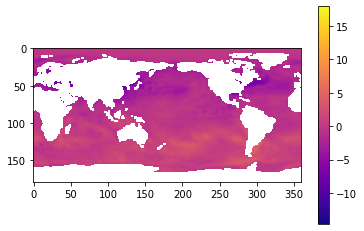

In [6]:
# Plot first time step

mode = 'mc' # 'raw' or 'mc'

sst_raw_masked = mask_sst(sst_raw, mask)
sst_masked = mask_sst(sst_st, mask)

if mode == 'raw':
    for_plot = sst_raw_masked
elif mode == 'mc':
    for_plot = sst_masked

vmin, vmax = for_plot.min(), for_plot.max()


plt.imshow(for_plot[:,:,0], cmap='plasma', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [4]:
# Make sst movie

k = 1000
loc = '/cnl/data/spate/Corn/sst_mc'
make_movie(sst_masked, k, loc, interval=50, cmap='plasma')

k = 1000
loc = '/cnl/data/spate/Corn/sst_raw'
make_movie(sst_raw_masked, k, loc, interval=50, cmap='plasma')

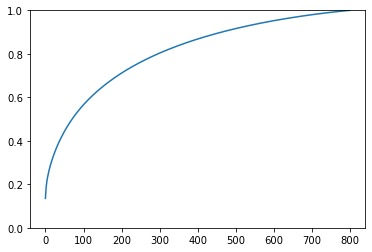

100 :  0.5660023307090809
150 :  0.6486738150351847
200 :  0.7117041342422373
250 :  0.7620669216815039
300 :  0.8036792246752308
350 :  0.8386338198281994
400 :  0.8684968674353608
450 :  0.8941918613396299
500 :  0.9164186108237764
550 :  0.9357992288451429
600 :  0.9527317982104198
650 :  0.9674483439694391
700 :  0.980210825830961
750 :  0.9911360955045347


In [100]:
# SVD

r = 800

u, s, vt = rand_svd(sst_st, r)
cum_energy = np.cumsum(s / s.sum())
plt.plot(cum_energy)
plt.ylim(0,1)
plt.show()

for i in range(100, r, 50):
    print(i, ': ',cum_energy[i])

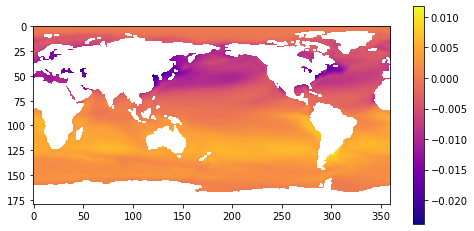

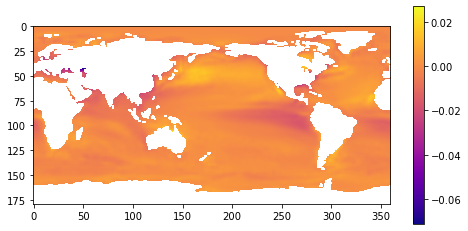

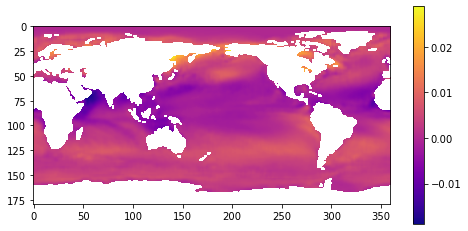

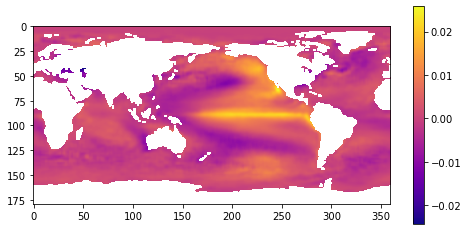

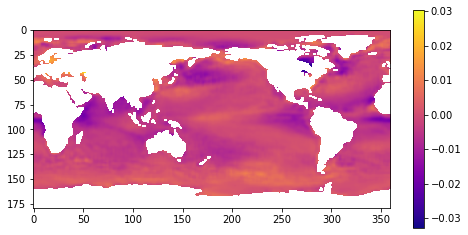

In [104]:
# Plot top n spatial modes 

n = 5

for i in range(n):
    fig, ax = plt.subplots(figsize=(8,4))
    u_plot = mask_sst(u[:,i].reshape(-1, 1), mask)
    cax = ax.imshow(u_plot[:,:,0], cmap='plasma')
    fig.colorbar(cax)
    plt.show()

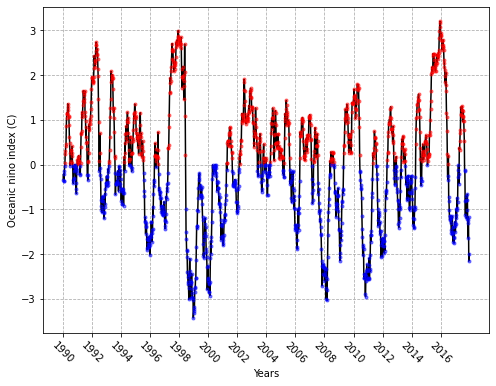

In [6]:
# Calculate oceanic nino index (ONI)

lat_min, lat_max = -0.5, 0.5
long_min, long_max = 190, 240 # Degrees east
alpha = 0.5
do_save = True

lat_idx = ((lat >= lat_min) & (lat <= lat_max))
long_idx = ((long >= long_min) & (long <= long_max))

nino_34 = sst_masked[lat_idx, :, :]
nino_34 = nino_34[:, long_idx, :]

oni = nino_34.mean(axis=0).mean(axis=0) - nino_34.mean()

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(time, oni, 'k-')
ax.plot(time[oni > 0], oni[oni > 0], 'r.', alpha=alpha)
ax.plot(time[oni < 0], oni[oni < 0], 'b.', alpha=alpha)

ax.set_xticks(time[::104])
ax.set_xticklabels(time[::104].astype(int), rotation=-45, ha='center')
ax.set_ylabel("Oceanic nino index (C)")
ax.set_xlabel("Years")
ax.grid(True, ls='--')

if do_save:
    plt.savefig(save_dir + 'oceanic_nino_index.png')

plt.show()

In [80]:
# Multi-resolution analysis

wav = 'db1'
level = 8
for l in range(1, level + 1):
    print(f"Period: {(2**l):.2f} weeks")

projs = pywt.mra(sst_st, wavelet=wav, level=level, transform='dwt') # Project signal onto wavelet space

for i in range(level + 1):
    print(f"Saving component {i}")
    if i == 0:
        np.savetxt(save_dir + f"sst_mra_n_levels_{level}_wav_{wav}_s0.csv", projs[0].reshape(-1, t_span), delimiter=',')
    else:
        np.savetxt(save_dir + f"sst_mra_n_levels_{level}_wav_{wav}_d{i}.csv", projs[-i].reshape(-1, t_span), delimiter=',')


Period: 2.00 weeks
Period: 4.00 weeks
Period: 8.00 weeks
Period: 16.00 weeks
Period: 32.00 weeks
Period: 64.00 weeks
Period: 128.00 weeks
Period: 256.00 weeks
Saving component 0
Saving component 1
Saving component 2
Saving component 3
Saving component 4
Saving component 5
Saving component 6
Saving component 7
Saving component 8


In [96]:
# Load MRA components

total_levels = 8
wav = 'db2'
levels = [7, 8]
projs = []

for l in levels:
    this_proj = np.loadtxt(save_dir + f"sst_mra_n_levels_{total_levels}_wav_{wav}_d{l}.csv", delimiter=',')
    this_proj = this_proj.reshape(-1, t_span)
    projs.append(this_proj)

In [97]:
# Load trend

trend = np.loadtxt(save_dir + f"sst_mra_n_levels_{total_levels}_wav_{wav}_s0.csv", delimiter=',')
trend = trend.reshape(-1, t_span)

In [86]:
# Select single MRA component. Mask it to compute ONI

level = 8
wav = 'db1'
idx = levels.index(level)
proj = projs[idx]
proj = mask_sst(proj, mask)

In [100]:
# Select mutliple MRA components, sum and mask them to compute ONI

add_trend = True

proj = np.zeros_like(projs[0])
for elt in projs:
    proj += elt

if add_trend:
    proj += trend

proj = mask_sst(proj, mask)


level = [str(l) for l in levels]
level = '_&_'.join(level)

if add_trend:
    level += '_&_trend'

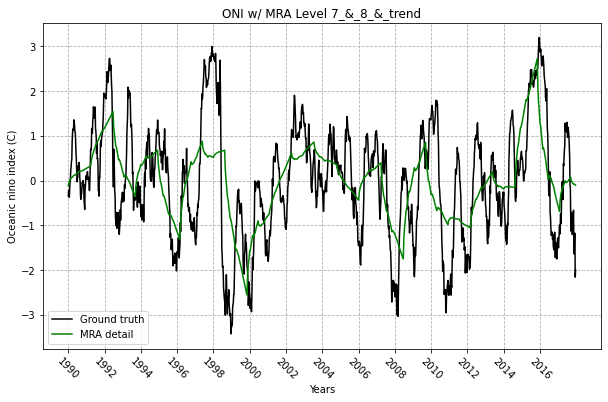

In [102]:
# Calculate ONI from MRA components

lat_min, lat_max = -0.5, 0.5
long_min, long_max = 190, 240 # Degrees east
do_save = True

lat_idx = ((lat >= lat_min) & (lat <= lat_max))
long_idx = ((long >= long_min) & (long <= long_max))

nino_34_hat = proj[lat_idx, :, :]
nino_34_hat = nino_34_hat[:,long_idx, :]

oni_hat = nino_34_hat.mean(axis=0).mean(axis=0) - nino_34_hat.mean()

# Plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot index from data
ax.plot(time, oni, 'k-', label='Ground truth')

# Plot projection
ax.plot(time, oni_hat, 'g-', label="MRA detail")

ax.set_xticks(time[::104])
ax.set_xticklabels(time[::104].astype(int), rotation=-45, ha='center')
ax.set_title(f"ONI w/ MRA Level {level}")
ax.grid(True, ls='--')
ax.set_ylabel("Oceanic nino index (C)")
ax.set_xlabel("Years")
plt.legend()

if do_save:
    plt.savefig(save_dir + f"oceanic_nino_index_mra_level_{level}_wav_{wav}.png")

plt.show()

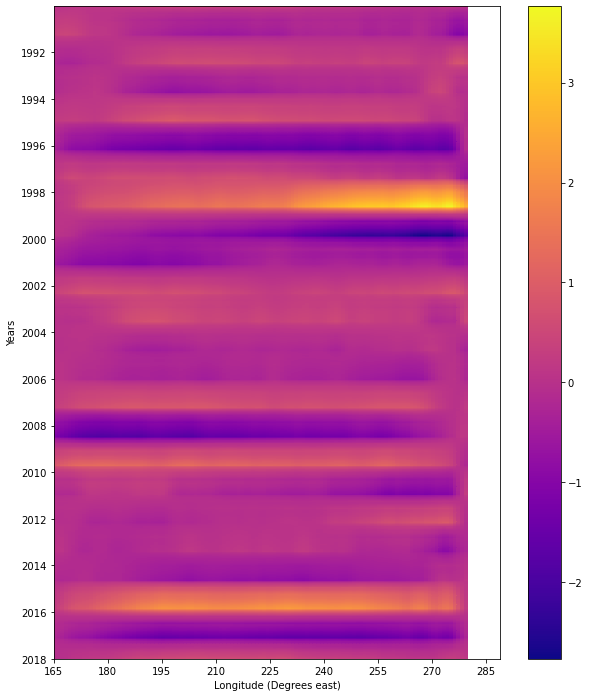

In [38]:
# Show tropical pacific slice to highlight ENSO

lat_min, lat_max = -0.5, 0.5
long_min, long_max = 165, 290
mode = 'mra' # 'data' or 'mra' depend. what you want to plot
do_save = True

lat_idx = ((lat >= lat_min) & (lat <= lat_max))
long_idx = ((long >= long_min) & (long <= long_max))

x = np.arange(long_min, long_max)
y = np.repeat(time[::-1], 2, axis=0)

# Select what to plot
if mode == 'mra':
    for_plot = proj
elif mode == 'data':
    for_plot = sst_raw_masked

# Index and reshape
for_plot = for_plot[lat_idx, :, :]
for_plot = for_plot[:, long_idx, :]
for_plot = np.transpose(for_plot, axes=[2,0,1]) # Time, lat, lon - want time to change most slowly during reshape, followed by lat, lon on 2nd axs
for_plot = for_plot.reshape(-1, for_plot.shape[-1])

# Plot
fig, ax = plt.subplots(figsize=(10,12))
im = ax.pcolormesh(x, y, for_plot, cmap='plasma', vmin=for_plot.min(), vmax=for_plot.max())
fig.colorbar(im)

ax.set_xticks(np.arange(long_min, long_max, 15))
ax.set_yticks(y[::-4*52])
ax.set_yticklabels(y[::4*52].astype(int))
ax.set_ylabel("Years")
ax.set_xlabel("Longitude (Degrees east)")

if do_save & (mode == 'mra'):
    plt.savefig(save_dir + f"sst_tropical_pacific_slice_mra_level_{level}_wav_{wav}.png")
elif do_save & (mode == 'data'):
    plt.savefig(save_dir + f"sst_tropical_pacific_slice_raw_data.png")

plt.show()

In [4]:
# Forecast SST with DMD

r = 500
mode = 'rand'
t0 = 52 * 0 # Start here
k = t_span - 1 # Go this many timesteps
x0 = sst_st[:,t0].reshape(-1,1)

dmd_model = dmd()
dmd_model.fit(sst_st, r, mode=mode)

sst_hat = dmd_model.predict(x0, k)
sst_hat = mask_sst(sst_hat, mask)

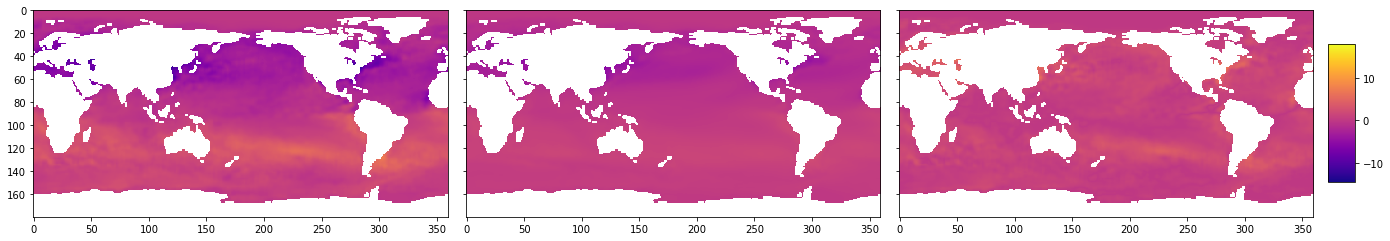

In [9]:
# Compare DMD prediction to data, visually
i = 1000

fig, ax = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8), sharey=True, sharex=True, constrained_layout=True)

vmin = min(sst_hat.min(), sst_masked.min())
vmax = max(sst_hat.max(), sst_masked.max())

ax[0].imshow(sst_masked[:,:,i], vmin=vmin, vmax=vmax, cmap='plasma')
ax[1].imshow(sst_hat[:,:,i], vmin=vmin, vmax=vmax, cmap='plasma')
im = ax[2].imshow(abs(sst_hat[:,:,i] - sst_masked[:,:,t0 + i]), vmin=vmin, vmax=vmax, cmap='plasma')

fig.colorbar(im, ax=ax[2], shrink=0.4)

plt.show()

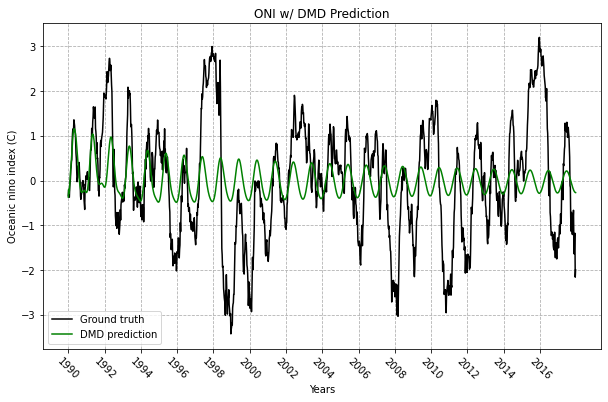

In [47]:
# Plot DMD prediction from x0 against ONI

lat_min, lat_max = -0.5, 0.5
long_min, long_max = 190, 240 # Degrees east
do_save = True

lat_idx = ((lat >= lat_min) & (lat <= lat_max))
long_idx = ((long >= long_min) & (long <= long_max))

nino_34_hat = sst_hat[lat_idx, :, :]
nino_34_hat = nino_34_hat[:,long_idx, :]

oni_hat = nino_34_hat.mean(axis=0).mean(axis=0) - nino_34_hat.mean()

# Plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot index from data
ax.plot(time[t0:t0 + k + 1], oni[t0:t0 + k + 1], 'k-', label="Ground truth")

# Plot projection
ax.plot(time[t0:t0 + k + 1], oni_hat, 'g-', label="DMD prediction")

ax.set_xticks(time[t0:t0 + k + 1:104])
ax.set_xticklabels(time[t0:t0 + k + 1:104].astype(int), rotation=-45, ha='center')
ax.set_title(f"ONI w/ DMD Prediction")
ax.grid(True, ls='--')
ax.set_ylabel("Oceanic nino index (C)")
ax.set_xlabel("Years")
plt.legend()

if do_save:
    plt.savefig(save_dir + f"oceanic_nino_index_dmd_prediction_from_t_{t0}.png")

plt.show()

In [ ]:
'''
to do
- Make movie of dmd v data differences to see where on earth sst fluctuations deviate from oscillatory
- predict enso with neural network - ff & rnn, and with raw data and wavelet features as training data
- find a way to standardize colorbar, esp if going to display them next to each other.
keep 0 at purple somehow? and normalize everything by stddev?
- look into wavelet packet transform if finer resolution in frequency helps?
'''

In [13]:
k = 1000
loc = '/cnl/data/spate/Corn/dmd_diff'
for_movie = abs(sst_hat - sst_masked)
make_movie(for_movie, k, loc, interval=50, cmap='plasma')

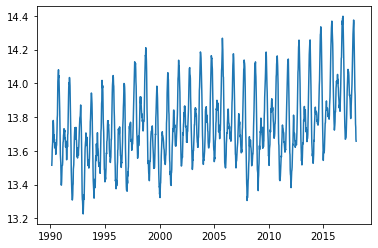

In [108]:
sst_ave = (sst_st + ave_week).mean(axis=0)


plt.plot(time, sst_ave)
plt.show()